In [1]:
import numpy as np

# ====== 配置 ======
POP = 200
GEN = 200
X_MIN = np.array([-5.0, -5.0])
X_MAX = np.array([ 5.0,  5.0])
PC = 0.9   # 交叉概率
PM = 0.2   # 变异概率
ETA_C = 15 # SBX 参数
ETA_M = 20 # 多项式变异参数
rng = np.random.default_rng(42)

# ====== 你的 6 目标函数（示例占位；替换为真实函数）======
def evaluate(x):  # x shape: (2,)
    # 举例：混合非线性 + 互相冲突的 6 目标
    x1, x2 = x
    return np.array([
        x1**2 + x2**2,
        (x1-2)**2 + (x2+1)**2,
        (x1+1)**2 + (x2-2)**2,
        (np.sin(3*x1)+1.5)**2 + (np.cos(3*x2)+1.5)**2,
        (abs(x1)+0.1)*(abs(x2)+0.2),
        0.5*(x1**2) + 3.0*(np.maximum(0,x2)) + 2.0*(np.maximum(0,-x2))
    ], dtype=float)

# ====== 工具：非支配排序 ======
def fast_non_dominated_sort(F):
    N = F.shape[0]
    S = [[] for _ in range(N)]
    n = np.zeros(N, dtype=int)
    fronts = [[]]

    for p in range(N):
        for q in range(N):
            if p == q: continue
            # p dominates q ?
            if np.all(F[p] <= F[q]) and np.any(F[p] < F[q]):
                S[p].append(q)
            elif np.all(F[q] <= F[p]) and np.any(F[q] < F[p]):
                n[p] += 1
        if n[p] == 0:
            fronts[0].append(p)

    i = 0
    while fronts[i]:
        Q = []
        for p in fronts[i]:
            for q in S[p]:
                n[q] -= 1
                if n[q] == 0:
                    Q.append(q)
        i += 1
        fronts.append(Q)
    fronts.pop()  # 最后一个为空
    return fronts

# ====== 工具：拥挤距离 ======
def crowding_distance(F, idxs):
    if len(idxs) == 0:
        return np.array([])
    M = F.shape[1]
    d = np.zeros(len(idxs))
    subF = F[idxs]
    # 归一化
    fmin = subF.min(axis=0); fmax = subF.max(axis=0)
    span = np.where(fmax > fmin, fmax - fmin, 1.0)
    normF = (subF - fmin) / span

    for m in range(M):
        order = np.argsort(normF[:, m])
        d[order[0]] = d[order[-1]] = np.inf
        for k in range(1, len(order)-1):
            d[order[k]] += normF[order[k+1], m] - normF[order[k-1], m]
    return d

# ====== 选择（锦标赛：等级优先，拥挤次之）======
def tournament_select(pop, F, ranks, distances):
    i, j = rng.integers(0, len(pop), size=2)
    a = (ranks[i], -distances[i])
    b = (ranks[j], -distances[j])
    return pop[i] if a < b else pop[j]

# ====== SBX 交叉 ======
def sbx_crossover(p1, p2):
    if rng.random() > PC:
        return p1.copy(), p2.copy()
    c1 = p1.copy(); c2 = p2.copy()
    for k in range(len(p1)):
        if rng.random() < 0.5:
            x1, x2 = sorted([p1[k], p2[k]])
            if abs(x1-x2) < 1e-14:
                continue
            u = rng.random()
            beta = 1.0 + (2.0*(x1 - X_MIN[k])/(x2 - x1))
            alpha = 2.0 - beta**-(ETA_C+1)
            if u <= 1.0/alpha:
                betaq = (u*alpha)**(1.0/(ETA_C+1))
            else:
                betaq = (1.0/(2.0 - u*alpha))**(1.0/(ETA_C+1))
            c1[k] = 0.5*((x1+x2) - betaq*(x2 - x1))

            beta = 1.0 + (2.0*(X_MAX[k]-x2)/(x2 - x1))
            alpha = 2.0 - beta**-(ETA_C+1)
            if u <= 1.0/alpha:
                betaq = (u*alpha)**(1.0/(ETA_C+1))
            else:
                betaq = (1.0/(2.0 - u*alpha))**(1.0/(ETA_C+1))
            c2[k] = 0.5*((x1+x2) + betaq*(x2 - x1))
    return np.clip(c1, X_MIN, X_MAX), np.clip(c2, X_MIN, X_MAX)

# ====== 多项式变异 ======
def poly_mutation(c):
    for k in range(len(c)):
        if rng.random() < PM:
            u = rng.random()
            if u < 0.5:
                delta = (2*u)**(1.0/(ETA_M+1)) - 1
            else:
                delta = 1 - (2*(1-u))**(1.0/(ETA_M+1))
            c[k] += delta*(X_MAX[k]-X_MIN[k])
    return np.clip(c, X_MIN, X_MAX)

# ====== 主循环 ======
def nsga2():
    # 初始化
    P = rng.uniform(X_MIN, X_MAX, size=(POP, 2))
    F = np.array([evaluate(x) for x in P])

    for _ in range(GEN):
        # 排序+距离
        fronts = fast_non_dominated_sort(F)
        rank = np.empty(POP, dtype=int)
        dist = np.zeros(POP)
        for r, fr in enumerate(fronts):
            rank[fr] = r
            dist[fr] = crowding_distance(F, fr)

        # 选择并生成子代
        offsprings = []
        while len(offsprings) < POP:
            p1 = tournament_select(P, F, rank, dist)
            p2 = tournament_select(P, F, rank, dist)
            c1, c2 = sbx_crossover(p1, p2)
            offsprings.append(poly_mutation(c1))
            if len(offsprings) < POP:
                offsprings.append(poly_mutation(c2))
        Q = np.array(offsprings)
        FQ = np.array([evaluate(x) for x in Q])

        # 环境选择
        R = np.vstack([P, Q])
        FR = np.vstack([F, FQ])
        fronts = fast_non_dominated_sort(FR)

        newP, newF = [], []
        for fr in fronts:
            if len(newP) + len(fr) <= POP:
                newP.extend(R[fr])
                newF.extend(FR[fr])
            else:
                # 需要裁剪
                d = crowding_distance(FR, fr)
                order = np.argsort(-d)  # 大距离优先
                need = POP - len(newP)
                sel = [fr[i] for i in order[:need]]
                newP.extend(R[sel]); newF.extend(FR[sel])
                break
        P = np.array(newP)
        F = np.array(newF)

    # 最终 Front 1 作为 Pareto 近似
    fronts = fast_non_dominated_sort(F)
    pareto_idx = np.array(fronts[0], dtype=int)
    return P, F, pareto_idx

# 运行
P, F, pareto_idx = nsga2()
pareto_X = P[pareto_idx]   # 决策空间中的 Pareto 域近似
pareto_F = F[pareto_idx]   # 目标空间中的 Pareto 前沿近似


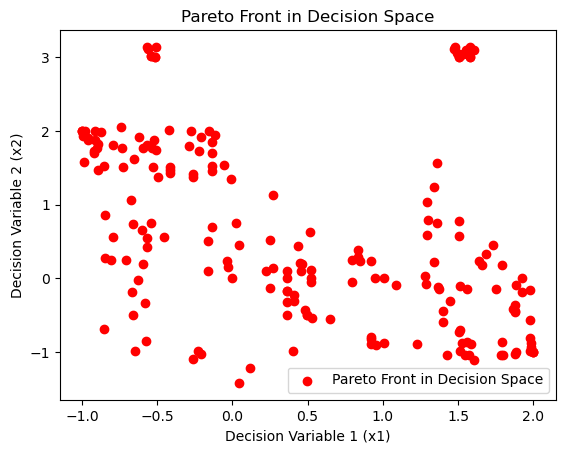

In [9]:
import matplotlib.pyplot as plt

# 假设 pareto_X 是决策空间中的 Pareto 解集（二维决策空间）
x1, x2 = pareto_X[:, 0], pareto_X[:, 1]

plt.scatter(x1, x2, color='r', label="Pareto Front in Decision Space")
plt.xlabel('Decision Variable 1 (x1)')
plt.ylabel('Decision Variable 2 (x2)')
plt.title('Pareto Front in Decision Space')
plt.legend()
plt.show()


